<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/05-nlp/03-transfer-learning/Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential,Model
import keras.utils as ku 
import numpy as np

Using TensorFlow backend.


In [0]:
data = """У лукоморья дуб зелёный;
Златая цепь на дубе том:
И днём и ночью кот учёный
Всё ходит по цепи кругом;
Идёт направо - песнь заводит,
Налево - сказку говорит.
Там чудеса: там леший бродит,
Русалка на ветвях сидит;
Там на неведомых дорожках
Следы невиданных зверей;
Избушка там на курьих ножках
Стоит без окон, без дверей;
Там лес и дол видений полны;
Там о заре прихлынут волны
На брег песчаный и пустой,
И тридцать витязей прекрасных
Чредой из вод выходят ясных,
И с ними дядька их морской;
Там королевич мимоходом
Пленяет грозного царя;
Там в облаках перед народом
Через леса, через моря
Колдун несёт богатыря;
В темнице там царевна тужит,
А бурый волк ей верно служит;
Там ступа с Бабою Ягой
Идёт, бредёт сама собой,
Там царь Кащей над златом чахнет;
Там русский дух... там Русью пахнет!
И там я был, и мёд я пил;
У моря видел дуб зелёный;
Под ним сидел, и кот учёный
Свои мне сказки говорил."""

In [0]:
tokenizer = Tokenizer()

In [0]:
def dataset_preparation(data):
	corpus = data.lower().split("\n")
  
	tokenizer.fit_on_texts(corpus)
	total_words = len(tokenizer.word_index) + 1

	input_sequences = []
	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			input_sequences.append(n_gram_sequence)

	max_sequence_len = max([len(x) for x in input_sequences])
	input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

	predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
	label = ku.to_categorical(label, num_classes=total_words)

	return predictors, label, max_sequence_len, total_words

In [0]:
def create_model(predictors, label, max_sequence_len, total_words):

    model = Sequential()
    model.add(Embedding(total_words, 32, input_length=max_sequence_len-1))
    
    model.add(LSTM(1024, return_sequences=True)) # 150
    model.add(LSTM(512)) # 100

    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

In [0]:
def generate_text(seed_text, next_words, max_sequence_len):
	for _ in range(next_words):
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = model.predict_classes(token_list, verbose=0)
		
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == predicted:
				output_word = word
				break
		seed_text += " " + output_word
	return seed_text

In [7]:
predictors, label, max_sequence_len, total_words = dataset_preparation(data)

print(f'predictors: {predictors.shape}, label: {label.shape}, max_sequence_len: {max_sequence_len}, total_words: {total_words}')

predictors: (124, 7), label: (124, 121), max_sequence_len: 8, total_words: 121


### Задача: 
Предсказать конец строки (обычно три слова) по первым двум словам.

\* _То есть по сути надо переобучить сеть_. 

In [8]:
earlystop = EarlyStopping(monitor='loss', min_delta=0., patience=5, verbose=0, mode='auto')

model = create_model(predictors, label, max_sequence_len, total_words)

model.fit(predictors, label, epochs=100, verbose=1, callbacks=[earlystop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
124/124 [==============================] - 3s 23ms/step - loss: 4.7989 - acc: 0.0161
Epoch 2/100
124/124 [==============================] - 0s 1ms/step - loss: 4.7829 - acc: 0.0403
Epoch 3/100
124/124 [==============================] - 0s 1ms/step - loss: 4.7179 - acc: 0.0403
Epoch 4/100
124/124 [==============================] - 0s 1ms/step - loss: 4.6745 - acc: 0.0403
Epoch 5/100
124/124 [==============================] - 0s 1ms/step - loss: 4.6343 - acc: 0.0403
Epoch 6/100
124/124 [==============================] - 0s 1ms/step - loss: 4.6136 - acc: 0.0403
Epoch 7/100
124/124 [==============================] - 0s 1ms/step - loss: 4.5842 - acc: 0.0565
Epoch 8/100
124/124 [==============================] - 0s 1ms/step - loss: 4.5604 - acc: 0.0565
Epoch 9/100
124/124 [==============================] - 0s 1ms/step - loss: 4.5138 - acc: 0.0645
Epoch 10/100
12

In [9]:
print(generate_text("Избушка там", 3, max_sequence_len))

Избушка там на курьих ножках


In [10]:
print(generate_text("У лукоморья", 2, max_sequence_len))

У лукоморья дуб зелёный


In [11]:
print(generate_text("Златая цепь", 3, max_sequence_len))

Златая цепь на дубе том


In [0]:
def predict_lines(data, tokenizer, max_sequence_len):
    corpus = data.lower().split("\n")
    for line in corpus:
        text = tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([line]))[0]
        words = text.split()
        print(generate_text(' '.join(words[:2]), len(words)-2, max_sequence_len))

In [13]:
predict_lines(data, tokenizer, max_sequence_len)

у лукоморья дуб зелёный
златая цепь на дубе том
и днём и ночью кот учёный
всё ходит по цепи кругом
идёт направо песнь заводит
налево сказку говорит
там чудеса там леший бродит
русалка на ветвях сидит
там на неведомых дорожках
следы невиданных зверей
избушка там на курьих ножках
стоит без окон без дверей
там лес и дол видений полны
там о заре прихлынут волны
на брег песчаный и пустой
и тридцать витязей прекрасных
чредой из вод выходят ясных
и с ними дядька их морской
там королевич мимоходом
пленяет грозного царя
там в облаках перед народом
через леса через моря
колдун несёт богатыря
в темнице там царевна тужит
а бурый волк ей верно служит
там ступа с бабою ягой
идёт бредёт сама собой
там царь кащей над златом чахнет
там русский дух там русью пахнет
и там я был и мёд я пил
у моря видел дуб зелёный
под ним сидел и кот учёный
свои мне сказки говорил


In [0]:
embl = model.layers[0]

In [0]:
from sklearn.decomposition import PCA
from matplotlib.pylab import plt

In [0]:
vl = PCA(n_components=2).fit_transform(embl.get_weights()[0])

In [0]:
viz_words=['дуб','дух','дядька','златом','златая','цепь','волк']

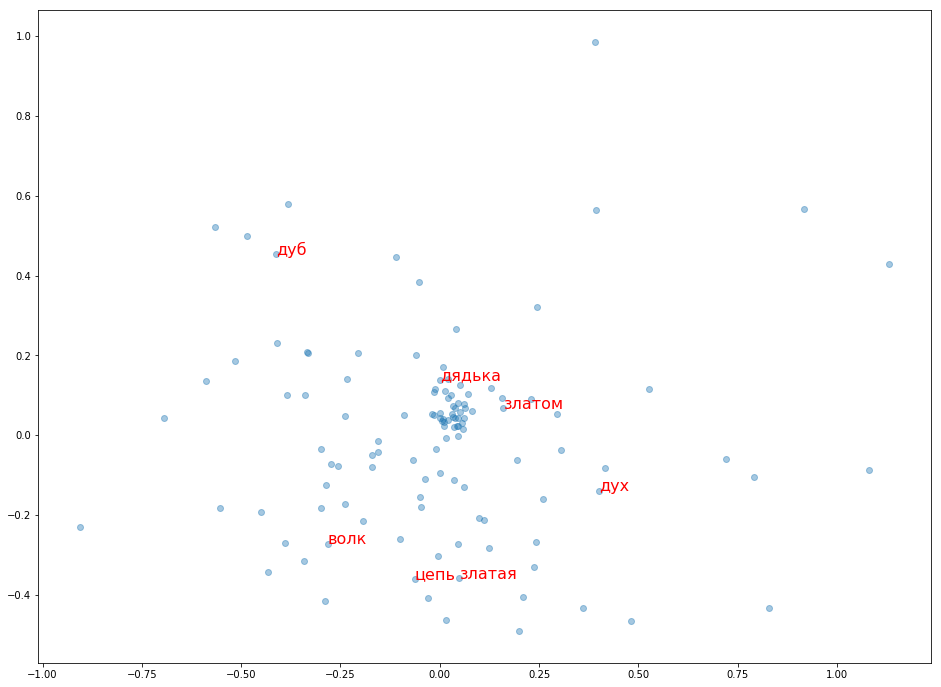

In [18]:
plt.figure(figsize=(16,12))
plt.scatter(vl[:,0],vl[:,1],alpha=0.4)
for word in viz_words:
  ind = tokenizer.word_index[word]

plt.text(vl[ind,0],vl[ind,1],word,color='red',size=16)

---

### Дополнительные материалы:

Список статей (с учетом времени):

https://arxiv.org/abs/1409.3215 - Sequence to Sequence Learning with Neural Networks

https://arxiv.org/abs/1409.0473 - Neural Machine Translation by Jointly Learning to Align and Translate


https://arxiv.org/abs/1508.04025 - Effective Approaches to Attention-based Neural Machine Translation

https://arxiv.org/abs/1705.03122 - Convolutional Sequence to Sequence Learning

https://arxiv.org/abs/1706.03762 - Attention Is All You Need

https://arxiv.org/abs/1810.04805 - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf - Language Models are Unsupervised Multitask Learners )(GPT-2)

https://arxiv.org/abs/1904.02679 - Visualizing Attention in Transformer-Based Language Representation Models


---

Хорошая статья с кодом на Pytorch-е http://nlp.seas.harvard.edu/2018/04/03/attention.html

----

Еще несколько статей с пояснениями:
https://medium.com/@bgg/seq2seq-pay-attention-to-self-attention-part-1-d332e85e9aad
https://medium.com/@bgg/seq2seq-pay-attention-to-self-attention-part-2-cf81bf32c73d

Видео с пояснениями от sim0nsays(можно найти в слаке ОДС) https://youtu.be/k63pDjKV3Ew